Построение и настройка модели случайного леса. Визуализация важности признаков.

Цель: В этом задании вам предстоит научиться предсказывать судьбу животных в приюте. Найдут ли их прежние хозяева? Заберут ли их домой к новым? Или судьба будет не так благосклонна? Ответ найдём в лесу

1. Скачиваем данные вот отсюда - https://www.kaggle.com/c/shelter-animal-outcomes/data
2. Знакомимся с данными, целевой переменной будет OutcomeType, соответственно OutcomeSubType необходимо выкинуть из данных
3. Как можно заметить, почти все переменные текстовые/категориальные - смиряемся с тем, что нужно будет пилить много новых признаков
4. Делим данные на train/test, чтобы все преобразования, связанные с построением новых признаков, мы обучали только на трейне, а применяли уже везде
5. Выкидываем ID, потому что не нужОн, всё, что категориальное и с небольшим числом уникальных значений кодируем при помощи LabelEncoder (заодно можно объяснить, почему достаточно использовать LabelEncoder вместо OneHotEncoder)
6. Остальные текстовые переменные, где очень много уникальных значений (вроде имени или цвета), можно закодировать по вашему вкусу, можно использовать частоту встречаемости, можно попробовать закодировать отдельные цвета LabelEncoder, и т.д.
7. Наконец, очень полезно будет на основании AgeuponOutcome создать обычную непрерывную переменную - возраст животного, а из переменной DateTime подергать отдельно год, месяц и день недели
8. Делаем бейзлайн на основании частоты встречаемости каждого класса, а затем учим лес и сравниваем качество (полезно будет смотреть на confusion_matrx и classification_report)
9. Настраиваем основные параметры леса при помощи randomsearch - n_estimators, max_depth, и еще можно class_weight
10. Визуализируем важность признаков 
11. Вы великолепны

Критерии оценки: Вся предобработка - 6 баллов

Модельки и важность - еще 4 балла

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from datetime import datetime, date, time

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

%matplotlib inline


In [2]:
data = pd.read_csv('train.csv')
data


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
...,...,...,...,...,...,...,...,...,...,...
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [5]:
data.nunique()


AnimalID          26729
Name               6374
DateTime          22918
OutcomeType           5
OutcomeSubtype       16
AnimalType            2
SexuponOutcome        5
AgeuponOutcome       44
Breed              1380
Color               366
dtype: int64

In [6]:
data.isnull().sum()


AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

## OutcomeType - целевой признак

In [7]:
data['OutcomeType'].value_counts()


Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [8]:
data['OutcomeType'].isnull().sum()


0

## AnimalType 

In [9]:
data['AnimalType'].value_counts()


Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [10]:
pd.crosstab(data['AnimalType'], data['OutcomeType'])


OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
AnimalType,,,,,
Cat,4272,147,710,500,5505
Dog,6497,50,845,4286,3917


In [11]:
# К хозяевам чаще возвращают собак, чем кошек.


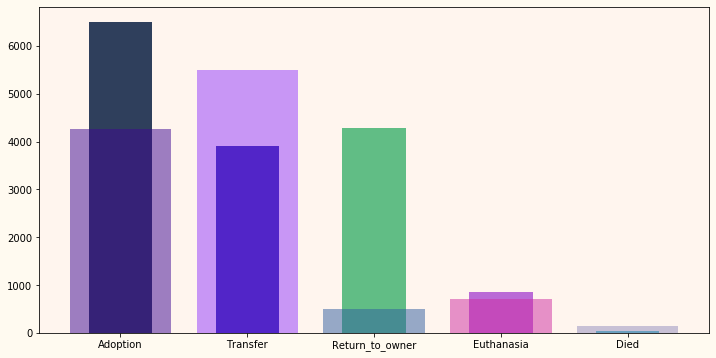

In [12]:
# Нашел такой способ представления баров - разной ширины:
x = data['OutcomeType'].value_counts().index.tolist()

sa_dog = data[data['AnimalType'] == 'Dog']['OutcomeType'].value_counts()
y1 = [sa_dog[i] for i in x]

sa_cat = data[data['AnimalType'] == 'Cat']['OutcomeType'].value_counts()
y2 = [sa_cat[i] for i in x]

fig, ax = plt.subplots()

color_rectangle = np.random.rand(7, 3)    # RGB
ax.bar(x, y1, color = color_rectangle, width = 0.5)

color_rectangle = np.random.rand(7, 4)    # RGBA
color_rectangle[:,3] = 0.5
ax.bar(x, y2, color = color_rectangle)

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

plt.show()

# Широкие бары - это кошки, узкие - собаки.


## SexuponOutcome

In [13]:
data['SexuponOutcome'].value_counts()


Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [14]:
pd.crosstab(data['OutcomeType'], data['SexuponOutcome'])


SexuponOutcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
OutcomeType,,,,,
Adoption,203,158,5222,5186,0
Died,56,79,19,18,25
Euthanasia,401,477,344,232,101
Return_to_owner,301,477,2247,1748,12
Transfer,2550,2334,1947,1636,955


In [15]:
# Чаще "усыновляют" кастрированных и стерилизованных животных.
# Transfer происходи чаще у не кастрированных и не стерилозованных животных
# SexuponOutcome - очень 'сильный' признак


## AgeuponOutcome

In [16]:
data['AgeuponOutcome'].value_counts()


1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
4 days         50
6 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

In [18]:
data['AgeuponOutcome'].nunique()


44

In [17]:
data['AgeuponOutcome'].unique()


array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       nan, '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [19]:
data['AgeuponOutcome'].isnull().sum()


18

In [20]:
pd.crosstab(data['AgeuponOutcome'], data['OutcomeType'])


OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
AgeuponOutcome,,,,,
0 years,0,1,2,0,19
1 day,0,2,0,6,58
1 month,444,48,131,11,647
1 week,0,3,6,0,137
1 weeks,0,3,6,0,162
1 year,1623,13,184,732,1417
10 months,238,1,6,51,161
10 years,108,9,69,156,104
11 months,80,0,2,34,50


In [21]:
# В основном погибают питомцы возраста 1 месяца.
# Чаще всего 'усыновляют' в возрасте 2 месяца и 1 год.


## Breed

In [22]:
data['Breed'].value_counts()


Domestic Shorthair Mix                        8810
Pit Bull Mix                                  1906
Chihuahua Shorthair Mix                       1766
Labrador Retriever Mix                        1363
Domestic Medium Hair Mix                       839
                                              ... 
Dalmatian/Labrador Retriever                     1
Beagle/Australian Cattle Dog                     1
Dachshund/Shetland Sheepdog                      1
American Pit Bull Terrier/American Bulldog       1
Border Terrier/West Highland                     1
Name: Breed, Length: 1380, dtype: int64

In [23]:
data['Breed'].nunique()


1380

In [28]:
data['Breed'].isnull().sum()


0

## Color

In [24]:
data['Color'].value_counts()


Black/White              2824
Black                    2292
Brown Tabby              1635
Brown Tabby/White         940
White                     931
                         ... 
Blue Cream/Blue Tiger       1
Tortie/Black Smoke          1
Chocolate/Brown Merle       1
Blue/Brown                  1
Blue Merle/Blue Merle       1
Name: Color, Length: 366, dtype: int64

In [25]:
data['Color'].nunique()


366

In [26]:
data['Color'].isnull().sum()


0

## DateTime

In [29]:
data['DateTime'].isnull().sum()


0

In [30]:
data['DateTime'].nunique()


22918

# Обработка данных

In [31]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size = 0.3, random_state = 0);

print(data_train.shape, data_test.shape)


(18710, 10) (8019, 10)


In [32]:
# Обработка данных:

from sklearn.base import BaseEstimator, ClassifierMixin

class MyDataProcessing(BaseEstimator, ClassifierMixin):
    
    def __init__(self):    
        pass
        
        
    def fit(self, data):
        '''
        Обучение модели
        '''
        big_columns = ['Color', 'Breed']
        small_columns = ['SexuponOutcome', 'AnimalType']
        
        # Обучимся на признаках с большим количеством уникальных значений:
        v_dict = []
        for column in big_columns:
            vv = {}
            list_1 = data[column].value_counts().index.tolist()
            list_2 = data[column].value_counts().tolist()
            if 'MyOther' in list_1:
                vv['MyOther'] = 0
                list_1.remove('MyOther')

            for j in range(0, len(list_1)):
                if j < 10:
                    vv[list_1[j]] = j + 1
                else:
                    vv[list_1[j]] = 0
            v_dict.append(vv)
        
        # Обучимся на признаках с малым количеством уникальных значений:
        le_dict = []
        for column in small_columns:
            list_s_1 = data[column].value_counts().index.tolist()
            list_s_2 = [j for j in range(0, len(list_s_1))]
            l_dict = dict(zip(list_s_1, list_s_2))
            le_dict.append(l_dict)
        
        # Обучимся на признаке "Name":
        popalur_names = data['Name'].value_counts().index.tolist()[:100]
        
#         name_dict = {}
#         list_n_1 = data['Name'].value_counts().index.tolist()
#         list_n_2 = data['Name'].value_counts().tolist()

        if 'MyOther' in popalur_names:
            popalur_names.remove('MyOther')

        self.v_dict = v_dict
        self.le_dict = le_dict
        self.popalur_names = popalur_names
        
        return self
    
        
    def transform(self, data):
        '''
        Трансформация данных
        '''
        v_dict = self.v_dict
        le_dict = self.le_dict
        popalur_names = self.popalur_names
        df = data.copy()
        
        df.drop(['OutcomeSubtype', 'AnimalID'], axis = 1, inplace = True)
        df = df.dropna(subset = ['AgeuponOutcome'])
        df.reset_index(drop = True, inplace = True)
        df = df.fillna("MyOther")
        
        big_columns = ['Color', 'Breed']
        small_columns = ['SexuponOutcome', 'AnimalType']
        
        # Закодируем признаки с большим количеством уникальных значений:
        for j in [0, 1]:
            def test_enc(i):
                if i in v_dict[j]:
                    return v_dict[j][i]
                else:
                    return 0
            df[big_columns[j]] = df[big_columns[j]].map(test_enc)
        
        # Закодируем признаки с малым количеством уникальных значений:
        for i in [0, 1]:
            l_dict = le_dict[i]
            unique_values = df[small_columns[i]].value_counts().index.tolist()    
            for j in unique_values:
                if j not in l_dict.keys():
                    l_dict[j] = -1
            df[small_columns[i]] = df[small_columns[i]].map(l_dict)
        
        # Закодируем признак "Name":
        def test_enc(i):
            if i in popalur_names:
                return 1
            else:
                return 0
        df['Name'] = df['Name'].map(test_enc)
        
        # Создадим новый признак возраст в днях:
        def get_age(i):
            d = i.split(' ')
            if 'year' in d[1]:
                itog = int(d[0]) * 365.2
            elif 'month' in d[1]:
                itog = int(d[0]) * 29.5
            elif 'week' in d[1]:
                itog = int(d[0]) * 7
            elif 'day' in d[1]:
                itog = int(d[0])
            return int(itog)
        df['Age_in_day'] = df['AgeuponOutcome'].map(get_age)
        df.drop('AgeuponOutcome', axis = 1, inplace = True)

        # Создадим новые признаки: год, месяц и день недели из признака 'DateTime':
        def get_time_data(df):
            df['DateTime'] = pd.to_datetime(df['DateTime'])

            df['Year'] = df['DateTime'].map(lambda x: x.year)
            df['month'] = df['DateTime'].map(lambda x: x.month)
            df['weekday'] = df['DateTime'].map(lambda x: datetime.weekday(x))
            df.drop('DateTime', axis = 1, inplace = True)
        get_time_data(df)
        
        return df


In [33]:
mymodel = MyDataProcessing()
mymodel.fit(data_test)


MyDataProcessing()

In [35]:
df_train = mymodel.transform(data_train)
df_train


,Name,OutcomeType,AnimalType,SexuponOutcome,Breed,Color,Age_in_day,Year,month,weekday
0,0,Return_to_owner,0,0,0,6,2556,2014,3,6
1,0,Euthanasia,0,2,0,9,2921,2014,11,3
2,0,Transfer,1,4,1,0,7,2015,6,3
3,0,Return_to_owner,1,0,1,1,118,2014,8,4
4,0,Adoption,1,1,1,0,59,2014,10,5
...,...,...,...,...,...,...,...,...,...,...
18695,0,Transfer,0,0,4,2,365,2015,8,1
18696,0,Adoption,1,1,1,0,1460,2014,12,4
18697,0,Transfer,1,2,7,2,28,2013,10,5
18698,0,Adoption,1,1,8,0,730,2015,3,5


In [36]:
df_test = mymodel.transform(data_test)
df_test


,Name,OutcomeType,AnimalType,SexuponOutcome,Breed,Color,Age_in_day,Year,month,weekday
0,0,Return_to_owner,0,0,0,2,365,2015,11,2
1,0,Adoption,0,1,3,0,59,2014,9,5
2,0,Return_to_owner,0,3,0,1,365,2015,11,0
3,0,Transfer,1,3,1,0,118,2014,8,6
4,0,Adoption,1,1,1,3,118,2013,10,0
...,...,...,...,...,...,...,...,...,...,...
8006,1,Transfer,0,3,3,1,59,2015,9,0
8007,0,Return_to_owner,1,0,5,1,730,2014,3,6
8008,0,Transfer,1,4,1,8,21,2015,8,0
8009,1,Adoption,1,1,1,8,88,2014,9,5


> ### "Почему достаточно использовать LabelEncoder вместо OneHotEncoder?"

Потому что мы будем использовать для обучени не линейные модели, т.е. модель не будет искать в значениях признаков порядок

|


# ML

In [37]:
X_train = df_train.drop('OutcomeType', axis = 1)
y_train = df_train['OutcomeType']

X_test = df_test.drop('OutcomeType', axis = 1)
y_test = df_test['OutcomeType']


## Baseline

In [38]:
from sklearn.dummy import DummyClassifier


In [39]:
new_dummy_classifier = DummyClassifier(strategy="stratified")
new_dummy_classifier.fit(X_train, y_train);

y_pred_stratified = new_dummy_classifier.predict(X_test)
target_names = X_train.columns.tolist()
print(classification_report(y_test, y_pred_stratified))


                 precision    recall  f1-score   support

       Adoption       0.40      0.40      0.40      3233
           Died       0.01      0.02      0.02        47
     Euthanasia       0.08      0.07      0.08       474
Return_to_owner       0.20      0.19      0.19      1452
       Transfer       0.36      0.36      0.36      2805

       accuracy                           0.33      8011
      macro avg       0.21      0.21      0.21      8011
   weighted avg       0.33      0.33      0.33      8011



In [40]:
new_dummy_classifier = DummyClassifier(strategy="most_frequent")
new_dummy_classifier.fit(X_train, y_train);
y_pred_most_frequent = new_dummy_classifier.predict(X_test)
target_names = X_train.columns.tolist()
print(classification_report(y_test, y_pred_most_frequent))


                 precision    recall  f1-score   support

       Adoption       0.40      1.00      0.58      3233
           Died       0.00      0.00      0.00        47
     Euthanasia       0.00      0.00      0.00       474
Return_to_owner       0.00      0.00      0.00      1452
       Transfer       0.00      0.00      0.00      2805

       accuracy                           0.40      8011
      macro avg       0.08      0.20      0.12      8011
   weighted avg       0.16      0.40      0.23      8011



/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

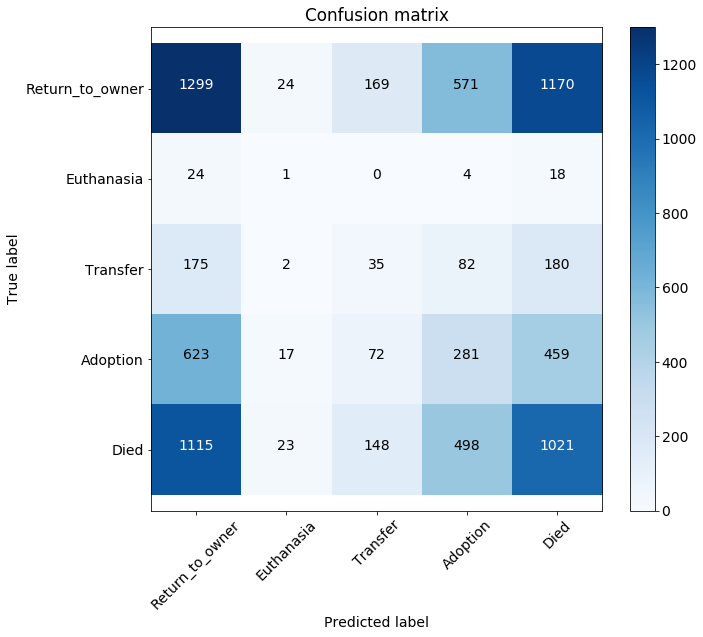

In [44]:
font = {'size' : 14}

plt.rc('font', **font)

class_names = df_train['OutcomeType'].unique().tolist()
cnf_matrix = confusion_matrix(y_test, y_pred_stratified)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
plt.axis('equal')
plt.savefig("conf_matrix.png")
plt.show();


## RandomForestClassifier

In [45]:
%%time
rf = RandomForestClassifier(criterion = 'entropy', random_state = 42, n_jobs = -1)
rf.fit(X_train, y_train);


CPU times: user 2.77 s, sys: 197 ms, total: 2.97 s
Wall time: 630 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
target_names = X_train.columns.tolist()
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


                 precision    recall  f1-score   support

       Adoption       0.66      0.77      0.71      3233
           Died       0.00      0.00      0.00        47
     Euthanasia       0.28      0.13      0.18       474
Return_to_owner       0.43      0.39      0.41      1452
       Transfer       0.67      0.64      0.66      2805

       accuracy                           0.61      8011
      macro avg       0.41      0.39      0.39      8011
   weighted avg       0.60      0.61      0.60      8011



In [47]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", 
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


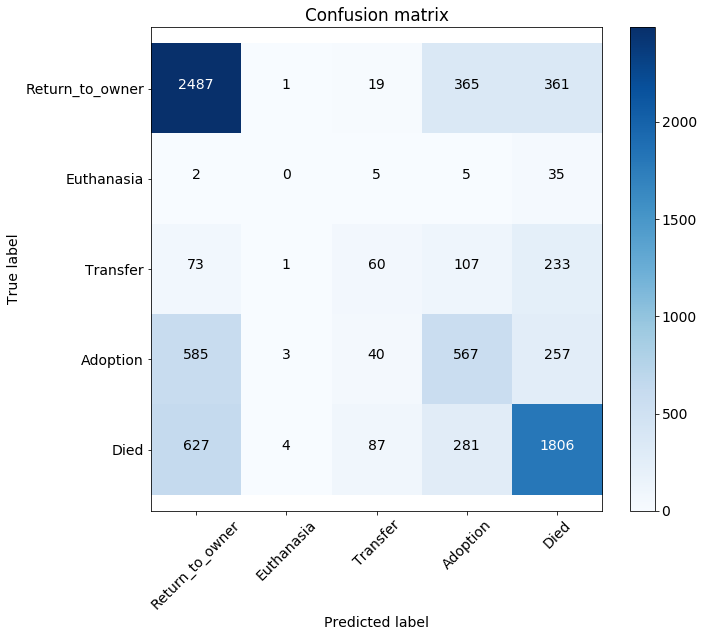

In [48]:
font = {'size' : 14}

plt.rc('font', **font)

class_names = df_train['OutcomeType'].unique().tolist()
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
plt.axis('equal')
plt.savefig("conf_matrix.png")
plt.show();


### RandomForestClassifier показал значительно лучший результат, чем Baseline.
|

In [49]:
# Визуализируем важность признаков:
fi = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
fi


Age_in_day        0.241709
SexuponOutcome    0.185030
month             0.169581
weekday           0.119100
Color             0.097995
Breed             0.070753
Year              0.057729
AnimalType        0.036077
Name              0.022025
dtype: float64

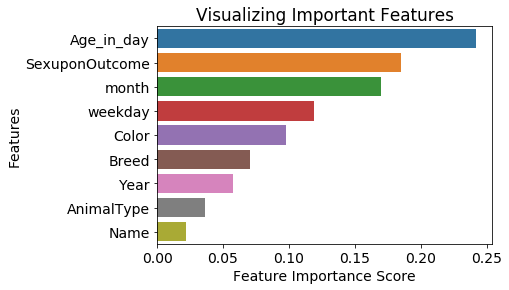

In [50]:
sns.barplot(x = fi, y = fi.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show();


## Настройка параметров модели:

In [51]:
rf = RandomForestClassifier(criterion = 'entropy', random_state = 42, n_jobs = -1, verbose = 1)

param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'class_weight': ('balanced', 'balanced_subsample', None)
}

rs = RandomizedSearchCV(rf, param_grid, n_jobs = -1, cv = 3, n_iter = 30, verbose = 1, random_state = 42)

rs.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [53]:
rs.best_params_


{'n_estimators': 13,
 'min_samples_split': 2,
 'max_leaf_nodes': 40,
 'max_features': 0.8999999999999999,
 'max_depth': 17,
 'class_weight': None,
 'bootstrap': True}

### Применим модель с подобранными параметрами:

In [54]:
best_model = rs.best_estimator_


In [55]:
target_names = X_train.columns.tolist()
y_pred_2 = best_model.predict(X_test)
print(classification_report(y_test, y_pred_2))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  13 out of  13 | elapsed:    0.0s finished
/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.66      0.85      0.74      3233
           Died       0.00      0.00      0.00        47
     Euthanasia       0.56      0.05      0.09       474
Return_to_owner       0.45      0.37      0.41      1452
       Transfer       0.71      0.67      0.69      2805

       accuracy                           0.65      8011
      macro avg       0.48      0.39      0.39      8011
   weighted avg       0.63      0.65      0.62      8011



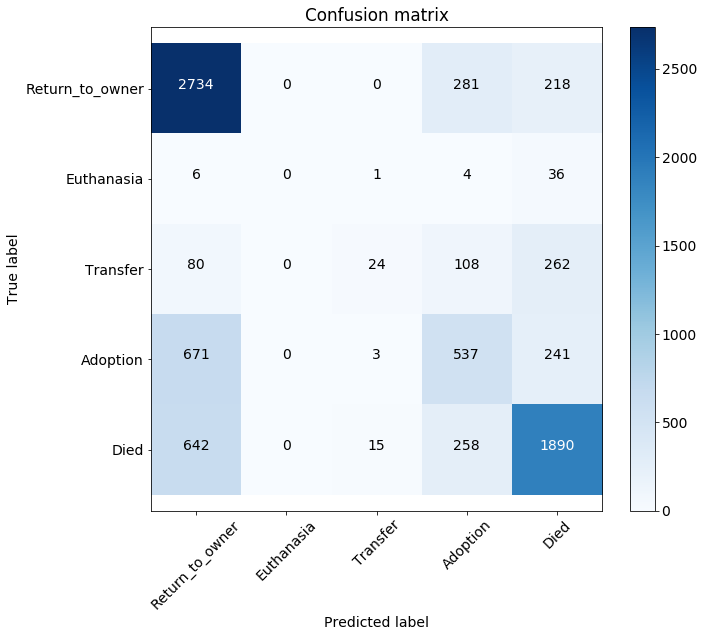

In [56]:
font = {'size' : 14}

plt.rc('font', **font)

class_names = df_train['OutcomeType'].unique().tolist()
cnf_matrix = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix');
plt.axis('equal')
plt.savefig("conf_matrix.png")
plt.show();


In [57]:
# Визуализируем важность признаков:
fi = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
fi


SexuponOutcome    0.512546
Age_in_day        0.325328
AnimalType        0.107304
weekday           0.036352
month             0.005862
Year              0.004837
Name              0.003915
Breed             0.003046
Color             0.000809
dtype: float64

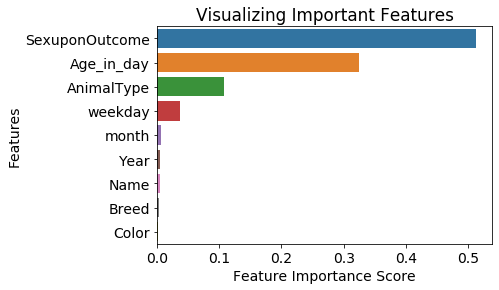

In [58]:
sns.barplot(x = fi, y = fi.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show();


# Результат

3-я важными признаками оказались 'SexuponOutcome', 'AgeuponOutcome' и 'AnimalType'.

Еще при анализе данных было видно, что эти признаки имеют разделение по целевой переменной.
